In [1]:
!pip3 install opencv-python matplotlib imutils jupyter sklearn tensorflow

     |████████████████████████████████| 50.4 MB 185 kB/s eta 0:00:01
     |███████████████████████▎        | 287.3 MB 76.9 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████████████████▋| 389.5 MB 91.4 MB/s eta 0:00:01

     |████████████████████████████████| 394.4 MB 91.4 MB/s eta 0:00:01

     |████████████████████████████████| 394.4 MB 14 kB/s 
     |████████████████████████████████| 10.6 MB 89.7 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 8.7 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 78.4 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 98.5 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 84.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 87.1 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 59.8 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 93.2 MB/s eta 0:00:01


  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=26743 sha256=2b2c75026db5c4ab5874cdc8fc5236a7eb02dd152f24c868e79db2983500c4b1
  Stored in directory: /root/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=5679 sha256=124ad7bda82ab74065e8264e0849a109868d042d09429e72f2fca9b7170ff849
  Stored in directory: /root/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=21397 sha256=37659f30c018dc04b05e99ca7fb904d3fbc9a652f20d49d6df49795955cbf741
  Stored in directory: /root/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built imutils termcolor wrapt
  Attempting uninstall: requests
    Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Attempting unin

In [2]:
!pip3 install --upgrade pip

In [12]:
## import packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from imutils import paths
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
 
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model,load_model, Model, Sequential
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, AveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

In [9]:
## data preprocessing
imagePath = "./all/train"
imagePaths = list(paths.list_images(imagePath))
data = []
labels = []
 
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    data.append(image)
    labels.append(label)

In [10]:
data = np.array(data) / 255.0
labels = np.array(labels)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels) # 라벨이 숫자로 변함
labels = to_categorical(integer_encoded) # 1,2,3 에서 (1, 0, 0), (0, 1, 0), (0, 0, 1)
 
# data를 160:40으로 변환
# train data: x_train (256*256*3), y_train (label)
# validation data :  x_val, y_val
(x_train, x_val, y_train, y_val) = train_test_split(data, labels, test_size=0.20, stratify=labels)

In [13]:
## AI model training
adam_s = Adam(learning_rate = 0.00001)

baseModel = InceptionV3(input_shape=(256, 256, 3),include_top=False, weights='imagenet')

for layer in baseModel.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


## Training에서 InceptionV3을 쓰는 이유
이미지 특성 모델은 보통 다음과 같은 구조를 거칩니다.

합성공 신경망 (특성 추출) 

-> Average2DPooling 및 평탄화 (Flatten)

(헤드 모델)

-> Dense layer를 이용해서 분류

우리의 데이터는 겨우 160개이기 때문에, 이미 훈련된 신경망을 가져와 쓸것입니다. (inceptionV3)

### 전이학습
BaseModel은 건드리지 않고 HeadModel만 훈련시킬 것입니다.
이런 방식을 전이 학습 (Transfer Learning) 이라고 합니다.

원래 InceptionV3도 Dense layer 부분이 있습니다. 여기서 1000개를 분류합니다.
하지만 우리는 3개의 분류를 합니다. (폐렴, 코비드, 정상)
그래서 Head를 재구성 해야 합니다.





In [14]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

# tensorflow는 모델 구조를 만들고 컴파일을 해줘야 한다.
model = Model(inputs=baseModel.input, outputs=headModel)
model.compile(loss='categorical_crossentropy', optimizer=adam_s, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
# training AI model
H = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=8)

Epoch 1/50
20/20 [==============================] - 11s 357ms/step - loss: 1.3140 - accuracy: 0.3252 - val_loss: 1.1125 - val_accuracy: 0.3500
Epoch 2/50
20/20 [==============================] - 5s 278ms/step - loss: 1.4159 - accuracy: 0.3185 - val_loss: 1.0959 - val_accuracy: 0.4000
Epoch 3/50
20/20 [==============================] - 6s 279ms/step - loss: 1.2987 - accuracy: 0.3930 - val_loss: 1.0766 - val_accuracy: 0.4250
Epoch 4/50
20/20 [==============================] - 5s 268ms/step - loss: 1.3062 - accuracy: 0.3272 - val_loss: 1.0617 - val_accuracy: 0.4500
Epoch 5/50
20/20 [==============================] - 6s 282ms/step - loss: 1.2515 - accuracy: 0.3457 - val_loss: 1.0429 - val_accuracy: 0.4750
Epoch 6/50
20/20 [==============================] - 6s 282ms/step - loss: 1.1698 - accuracy: 0.3132 - val_loss: 1.0275 - val_accuracy: 0.4750
Epoch 7/50
20/20 [==============================] - 5s 271ms/step - loss: 1.1596 - accuracy: 0.4464 - val_loss: 1.0126 - val_accuracy: 0.5250
Epoch

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
## save AI model
# 반드시 최종 Leaf 폴더가 숫자로 이루어져 있어야 합니다.
save_model(model, "head-base-covid/1")
model.save("inceptionv3_base.h5")

INFO:tensorflow:Assets written to: head-base-covid/1/assets


[[11  0  1]
 [ 0 12  2]
 [ 1  0 13]]
 
accuracy: 0.9000
sensitivity: 0.9167
specificity: 0.9643


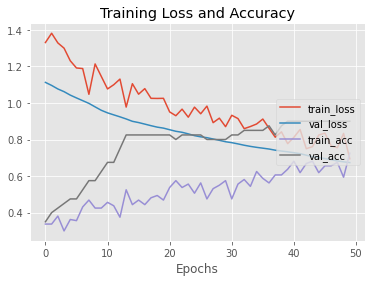

In [19]:
# Visualization (Optional)
P = model.predict(x_val, batch_size=8)
P = np.argmax(P, axis=1)
# print(classification_report(y_val.argmax(axis=1), P, target_names=label_encoder.classes_))
 
epochs = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.savefig("./s-class-plot-2.png")
 
cm = confusion_matrix(y_val.argmax(axis=1), P)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])
 
print(cm)
print(" ")
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [20]:
# import packages
import numpy as np
import cv2
import random
import os
import json
import requests
from imutils import paths
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [21]:
# Image preprocessing
imagePathTest = "./all/test"
imagePathsTest = list(paths.list_images(imagePathTest))
 
dataTest = []
labelsTest = []
 
for imagePathTest in imagePathsTest:
    labelTest = imagePathTest.split(os.path.sep)[-2]
    imageTest = cv2.imread(imagePathTest)
    imageTest = cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB)
    imageTest = cv2.resize(imageTest, (256, 256))
    dataTest.append(imageTest)
    labelsTest.append(labelTest)
     
dataTest = np.array(dataTest) / 255.0
labelsTest = np.array(labelsTest)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelsTest)
labelsTest = to_categorical(integer_encoded)

In [23]:
# Choose a random image and make JSON
sam = random.randint(0, len(imagePathsTest)-1)
print(sam)

15


In [24]:
sample_test_data = dataTest[sam]
sample_test_labels = labelsTest[sam]
# sam에 맞는 그림을 선택 (256, 256, 3)
sample_test_data = np.expand_dims(sample_test_data, axis=0)

data = json.dumps({"signature_name": "serving_default",
                   "instances": sample_test_data.tolist()})

In [25]:
with open("please.json", "w") as text_file:
    text_file.write("%s" % data) 

In [26]:
!curl 35.230.4.132:8501/v1/models/covid/versions/1:predict -X POST -d@please.json

{
    "predictions": [[0.00630468689, 0.825723886, 0.167971417]
    ]
}

In [27]:
# Get a prediction for JSON
json_response = requests.post('http://35.230.4.132:8501/v1/models/covid:predict', data=data)
predictions = json.loads(json_response.text)['predictions']
print(predictions[0])

[0.00630468689, 0.825723886, 0.167971417]
